<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Steganography</p><br>
<p>An image carries two messages: one encrypted steganography, and the password to decrypt it. The password can be revealed through increasing the contrast of the image and lowering its luminosity.</p>
<p><strong>Sources:</strong></p>

- game: www.ouverture-facile.com level 26. To avoid spoiling the game the name of the image was modified. The encryption password and the result of the steganography are also not displayed.

- simple steganography: https://github.com/srli/image_steganography/blob/master/steganography.py / http://blog.justsophie.com/image-steganography-in-python/

- encrypted steganography: https://github.com/arjunsk/Encrypted-Steganography/blob/master/code.py

In [1]:
"""A program that encodes and decodes hidden messages in images through LSB steganography"""
from PIL import Image, ImageFont, ImageDraw
import numpy as np

In [2]:
image = Image.open('./secret.jpg')

### 1. Change the luminosity and contrast of the image to reveal the password

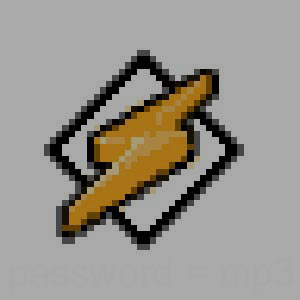

In [3]:
def change_luminosity(img,constant):
    # constant by which each pixel is divided
    source = img.split()
    if len(np.array(img).shape)==3: #i.e. RGB
        Red = source[0].point(lambda i: i/constant)
        Green = source[1].point(lambda i: i/constant)
        Blue = source[2].point(lambda i: i/constant)
        im = Image.merge(img.mode, (Red, Green, Blue))
    else:
        im=source[0].point(lambda i:i/constant) #for greyscale images
    return im
change_luminosity(image,1.5)

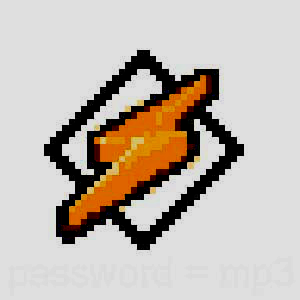

In [4]:
def change_contrast(img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)
change_contrast(change_luminosity(image,1.5), 100)

Superimposing a contrast enhancement to a lower luminosity reveals the password. If we consider that those methods are not sufficient, we can change the image pixel by pixel.

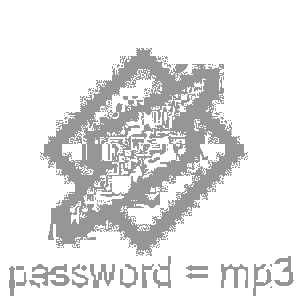

In [5]:
def retrieve_password(img):  
    decoded_image = Image.new("RGB", img.size,(255, 255, 255))
    pixels = decoded_image.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            px=img.load()[i,j][0]
            if px==254:
                pixels[i,j]=(255,255,255)
            elif px<254:
                pixels[i,j]=(150,150,150)
    return display(decoded_image)
retrieve_password(image)

In [6]:
image_np=np.array(image)
code=[]
for i in image_np:
    for j in i:
        if j[0]==j[1]==j[2] and not j[0]==255 and not j[1]==255 and not j[2]==255:
            code.append(j[0])
len(code)

12115

In [7]:
#XOR Cypher
from __future__ import print_function, unicode_literals
from os import urandom


def genkey(length):
    """Generate key"""
    return urandom(length)
    

def xor_strings(s, t):
    """xor two strings together"""
    if isinstance(s, str):
        # Text strings contain single characters
        return "".join(chr(ord(a) ^ ord(b)) for a, b in zip(s, t))
    else:
        # Python 3 bytes objects contain integer values in the range 0-255
        return bytes([a ^ b for a, b in zip(s, t)])
        

message = 'cypher'
print('message:', message)

key = genkey(len(message))
print('key:', key)

cipherText = xor_strings(message.encode('utf8'), key)
print('cipherText:', cipherText)
print('decrypted:', xor_strings(cipherText, key).decode('utf8'))

# verify
if xor_strings(cipherText, key).decode('utf8') == message:
    print('Unit test passed')
else:
    print('Unit test failed')

message: cypher
key: b'\x06a[\x95\x13\x07'
cipherText: b'e\x18+\xfdvu'
decrypted: cypher
Unit test passed


### 2. Encrypted Steganography

In [8]:
import binascii #Convert between binary and ASCII
#from Crypto.Cipher import AES
import base64

In [9]:
def rgb2hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def hex2rgb(hexcode):
    h=hexcode.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2 ,4))

In [10]:
def str2bin(message):
    message=str.encode(message) #encode the string (returns b'message). We can also use codecs.encode(message) or bytes(message,'utf-8')
    message1=binascii.hexlify(message) #encodes as an hexadecimal
    message2=int(message1,16) #transforms into a number
    binary = bin(message2) #transforms into binary
    return binary[2:] #removes the prefix '0b'

def bin2str(binary):
    message = binascii.unhexlify('%x' % (int('0b'+binary,2)))
    return message

In [11]:
def local_encode(hexcode, digit):
    if hexcode[-1] in ('0','1', '2', '3', '4', '5'):
        hexcode = hexcode[:-1] + digit
        return hexcode
    else:
        return None

def local_decode(hexcode):
    if hexcode[-1] in ('0', '1'):
        return hexcode[-1]
    else:
        return None

<strong>Hide</strong>
1. Turn message to binary
2. Append a suffix to act as a stop key
3. Hide in the image data: encode together(A,B), i.e. if A ends with a digit < 5 replace the last digit with B (0 or 1). If not, don't modify.
<p>A = rgb2hex(R, G, B), i.e. creates a string concatenating the 2-digit hexadecimals for the R G B numbers. Max 2 digits as hex(256)=100.<br> The encoding is done in the blue channel and on the hex encoding's lower 5 digits (i.e. maximum hex(149)=95).</p>
<p>B = one of the digits in the message coded in binary</p>
<p>Note that we could turn only the blue-channel data into hexadecimal since only this one is used (same comment about decoding)</p>

In [12]:
def hide(img,name,message):
    binary = str2bin(message) + '1111111111111110'
    if img.mode in ('RGBA'):
        img = img.convert('RGBA')
        datas = img.getdata()
        newData = []
        digit = 0
        temp = ''
        for item in datas:
            if (digit < len(binary)):
                newpix = local_encode(rgb2hex(item[0],item[1],item[2]),binary[digit])
                if newpix == None:
                    newData.append(item)
                else:
                    r, g, b = hex2rgb(newpix)
                    newData.append((r,g,b,255))
                    digit += 1
            else:
                newData.append(item)
        img.putdata(newData)
        img.save('encoded_{}.png'.format(name), "PNG")
        return "Completed!"
    return "Incorrect Image Mode, Couldn't Hide"

<strong>Retrieve</strong>
1. get tuples of RGB for the encoded_image
2. get back binary from the image data: turn the RGB into hex and decode, i.e. return the last hex digit if it's 0 or 1 and add it to the variable 'binary'.
3. Check when the stop key is reached and stop decoding.
3. Transform the resulting binary string into a string.

In [13]:
def retr(img):
    binary = ''
    if img.mode in ('RGBA'):
        img = img.convert('RGBA')
        datas = img.getdata() #returns tuples of RGB for each pixel
        for item in datas:
            digit = local_decode(rgb2hex(item[0],item[1],item[2]))
            if digit == None:
                pass
            else:
                binary = binary + digit
                if (binary[-16:] == '1111111111111110'):
                    print("Success! Encrypted message is : ")
                    return bin2str(binary[:-16])
        return bin2str(binary)
    return "Incorrect Image Mode, Couldn't Retrieve"

Instead of the Crypto library used by the author of https://github.com/arjunsk/Encrypted-Steganography/blob/master/code.py I decided to use the more mainstream cryptography library, and to change the encryption mode from ECB to CBC as it is more secure.
- ECB (Electronic Code Book) is the simplest mode of operation for block ciphers. Each block of data is encrypted in the same way. This means identical plaintext blocks will always result in identical ciphertext blocks, which can leave significant patterns in the output.
- CBC (Cipher Block Chaining) is a mode of operation for block ciphers. It is considered cryptographically strong.

In [19]:
import wx #library for GUI (elaborate user input such as dialog boxes)
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
import os

def Main(img,name='image'):
    app = wx.App()
    dialog=wx.SingleChoiceDialog(None,'Do you want to encrypt or decrypt an image?','Encryption/Decryption',['Encrypt','Decrypt'])
    if dialog.ShowModal()==wx.ID_OK:
        option=dialog.GetStringSelection()
    if option=='Encrypt':
        password = input("Enter your password: ")
        text=input('Enter a message to hide: ')
        print(str.encode(text))
        padded_pwd=str.encode(password.rjust(16,'0'))
        iv = os.urandom(16)
        cipher=Cipher(algorithms.AES(padded_pwd), modes.CBC(iv), backend=default_backend())
        encryptor = cipher.encryptor()
        #text = encryptor.update(str.encode(text)) + encryptor.finalize()
        text=encryptor.update(str.encode(text))
        text=text.decode('utf-8')
        
        #cipher = AES.new(password.rjust(16),AES.MODE_ECB) 
        #encoded = base64.b64encode(cipher.encrypt(text.rjust(32)))
        #print(hide(img,name,encoded))
        print(hide(img,name,text))
    elif option=='Decrypt':
        #password = input("Enter your password: ")
        #padded_pwd=password.rjust(16,'0')
        #cipher=Cipher(algorithms.AES(password.rjust(16)), modes.CBC(16*'0'), backend=default_backend())
        #decryptor = cipher.decryptor()
        #decryptor.update(encr_text) + decryptor.finalize()
        #cipher = AES.new(password.rjust(16),AES.MODE_ECB)
        #decoded = cipher.decrypt(base64.b64decode(retr(img)))
        #print(decoded.strip())
        print(retr(img))

In [20]:
waldo=Image.open('./Waldo.jpg')
encoded_waldo=Image.open('./encoded_image.png')
if __name__ == '__main__':
    Main(encoded_waldo)

Enter your password: mp3
Enter a message to hide: dgf
b'dgf'


ValueError: invalid literal for int() with base 16: b''

### 3. Non-encrypted steganography

In [ ]:
encoded_sample=Image.open('./encoded_sample.png')
display(encoded_sample)

In [ ]:
def decode_image(img):
    """Decodes the hidden message in an image (assuming it is hidden in the LSB of the red channel)
    file_location: the location of the image file to decode. By default is the provided encoded image in the images folder
    """
    red_channel = img.split()[0].load()
    decoded_image = Image.new("RGB", img.size,(255,255,255))
    pixels = decoded_image.load()
    for i in range(img.size[0]):
        for j in range(img.size[1]):
            if red_channel[i,j]&1==1: #the '&1' retrieves the LSB from the binary form of the 
                pixels[i,j]=(0,0,0)
    return decoded_image
decode_image(encoded_sample)

In [ ]:
def write_text(text_to_write, image_size):
    """Writes text to an RGB image. Automatically line wraps
    text_to_write: the text to write to the image
    image_size: size of the resulting text image. Is a tuple (x_size, y_size)
    """
    image_text = Image.new("RGB", image_size)
    font = ImageFont.load_default().font
    drawer = ImageDraw.Draw(image_text)

    #Text wrapping. Change parameters for different text formatting
    margin = offset = 10
    for line in textwrap.wrap(text_to_write, width=60):
        drawer.text((margin,offset), line, font=font)
        offset += 10
    return image_text
write_text('Hello!',(300,300))

In [ ]:
def encode_image(text_to_encode, template_image="images/samoyed.jpg"):
    """Encodes a text message into an image
    text_to_encode: the text to encode into the template image
    template_image: the image to use for encoding. An image is provided by default.
    """
    pass #TODO: Fill out this function

In [ ]:
if __name__ == '__main__':
    print("Decoding the image...")
    decode_image()

    print("Encoding the image...")
    encode_image()